# Reviews Company

In [1]:
# !conda install -c conda-forge sentence-transformers
# !pip install scikit-learn
# !pip install numpy pandas
# !pip show sentence-transformers
# !pip install spacy

In [2]:
# import required packages
import pandas as pd
import numpy as np
import spacy
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, normalize
from spacy.matcher import PhraseMatcher
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore")

2025-10-13 10:39:05.617641: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
pd.set_option("display.max_colwidth",None)
# pd.reset_option("display.max_row",None)

In [4]:
data = pd.read_csv("Data_Merge_Reviews.csv")
data

,Job Title,Job Rating,Time,Job Status,Pros,Cons,Company_Name
0,Brand Ambassador,5.0,2025-08-08,"Former employee, more than 1 year","Flexible Hours, Supportive Team, Good Training, Fun Work Environment, Opportunity To Travel.","Inconsistent Hours, Limited Career Growth, Commission Structure Can Be Unclear, Standing For Long Hours, Sometimes Slow Communication.",Safaricom
1,Senior Mobile Developer,4.0,2025-07-28,"Current contractor, more than 1 year",Great For Gaining Experience On Large Scale Enterprise Applications,A Lot Of Shifting Priorities,Safaricom
2,Project Manager,4.0,2025-07-15,"Former employee, more than 3 years","Strong Support For Professional Growth Through Training Exposure To LargeScale, Impactful Projects Across Kenya Competitive Salary And PerformanceBased Bonuses",Occasional Tight Deadlines And HighPressure Timelines Bureaucracy Can Delay Project SignOffs,Safaricom
3,Ict Technician,5.0,2025-07-18,Former employee,The Working Experience Was Good,There Are No Major Drawbacks I Can Talk About,Safaricom
4,Intern,5.0,2025-07-15,"Former intern, less than 1 year",Great Work Environment. Regular Bonuses.,None I Can Think Of,Safaricom
...,...,...,...,...,...,...,...
25037,Planning officer,4.0,2022-03-31,Former employee,have good medical covers for employees,terms of employment are contract,Equity
25038,Senior business analyst,4.0,2022-05-14,Current employee,Has good Learning potential for staff,Working schedule is not flexible,Equity
25039,Senior program manager,3.0,2016-05-02,Former employee,Potential for great social impact,Can be slow at times,Equity
25040,Ban assurance officer,1.0,2022-10-17,"Former employee, more than 1 year",Medical insurance cover. Low interest loans for staff,Bad management Less than appropriate pay Extremely long work hours Extensive workload Toxic work culture,Equity


In [5]:
# using 
data2 = data

In [6]:
def split_info(df: pd.Series)-> pd.DataFrame:
    employment_type = []
    role_type = []
    duration = []
    for raw in df:
        data = raw.split()
        emp = rol = dur = "default"

        if len(data) >=2:
            emp = data[0]
            rol = data[1].replace(",", "")

        if "less than 1 year" in raw:
            dur = "<1 year"
        elif "more than 1 year" in raw:
            dur = "1 - 3 year"
        elif "more than 3 years" in raw:
            dur = ">3 year"
        employment_type.append(emp)
        role_type.append(rol)
        duration.append(dur)
         
    return pd.DataFrame({
       "Employment_Type":employment_type,
        "Role_Type":role_type,
        "Duration":duration
    })
new_cols = split_info(data2["Job Status"])

In [7]:
data2 = pd.concat([data2, new_cols], axis=1)
data2 = data2[
    ["Job Title", "Job Rating", "Time", "Job Status", 
     "Employment_Type", "Role_Type", "Duration",
     "Pros", "Cons", "Company_Name"]
]

In [8]:
# data2.drop(["Employment_Type", "Role_Type", "Duration"], axis=1, inplace=True)

In [9]:
data2

,Job Title,Job Rating,Time,Job Status,Employment_Type,Role_Type,Duration,Pros,Cons,Company_Name
0,Brand Ambassador,5.0,2025-08-08,"Former employee, more than 1 year",Former,employee,1 - 3 year,"Flexible Hours, Supportive Team, Good Training, Fun Work Environment, Opportunity To Travel.","Inconsistent Hours, Limited Career Growth, Commission Structure Can Be Unclear, Standing For Long Hours, Sometimes Slow Communication.",Safaricom
1,Senior Mobile Developer,4.0,2025-07-28,"Current contractor, more than 1 year",Current,contractor,1 - 3 year,Great For Gaining Experience On Large Scale Enterprise Applications,A Lot Of Shifting Priorities,Safaricom
2,Project Manager,4.0,2025-07-15,"Former employee, more than 3 years",Former,employee,>3 year,"Strong Support For Professional Growth Through Training Exposure To LargeScale, Impactful Projects Across Kenya Competitive Salary And PerformanceBased Bonuses",Occasional Tight Deadlines And HighPressure Timelines Bureaucracy Can Delay Project SignOffs,Safaricom
3,Ict Technician,5.0,2025-07-18,Former employee,Former,employee,default,The Working Experience Was Good,There Are No Major Drawbacks I Can Talk About,Safaricom
4,Intern,5.0,2025-07-15,"Former intern, less than 1 year",Former,intern,<1 year,Great Work Environment. Regular Bonuses.,None I Can Think Of,Safaricom
...,...,...,...,...,...,...,...,...,...,...
25037,Planning officer,4.0,2022-03-31,Former employee,Former,employee,default,have good medical covers for employees,terms of employment are contract,Equity
25038,Senior business analyst,4.0,2022-05-14,Current employee,Current,employee,default,Has good Learning potential for staff,Working schedule is not flexible,Equity
25039,Senior program manager,3.0,2016-05-02,Former employee,Former,employee,default,Potential for great social impact,Can be slow at times,Equity
25040,Ban assurance officer,1.0,2022-10-17,"Former employee, more than 1 year",Former,employee,1 - 3 year,Medical insurance cover. Low interest loans for staff,Bad management Less than appropriate pay Extremely long work hours Extensive workload Toxic work culture,Equity


In [10]:
data2["Employment_Type"].unique().tolist()

['Former', 'Current', 'KEY']

In [11]:
data2[data2["Employment_Type"] == "KEY"]

,Job Title,Job Rating,Time,Job Status,Employment_Type,Role_Type,Duration,Pros,Cons,Company_Name
467,Online Data Entry,5.0,2021-07-21,KEY NOT FOUND: jobLine.seasonal-current,KEY,NOT,default,The Company Pays Well And On Time,Commissions Were Very Few Also Allowances,Safaricom


In [12]:
data2.drop(467, axis=0, inplace=True)

In [13]:
data2.set_index("Job Title", inplace=True)

In [14]:
data2= data2.reset_index()

In [15]:
data2["Role_Type"].unique().tolist()

['employee', 'contractor', 'intern', 'temporary', 'freelancer']

In [16]:
# jobrole = {"intern":"Internship"}

In [17]:
data2["Role_Type"].replace("intern", "internship",inplace=True)

In [18]:
# Normalize text (lowercase, remove weird symbols, etc.).
data2["Pros"] = data2["Pros"].str.lower()

In [19]:
data2["Job Title"] = data2["Job Title"].str.lower()

In [20]:
# This command is used to change the it's to it is 
import contractions
data2["Cons"] = data2["Cons"].apply(lambda x: contractions.fix(x) if isinstance(x, str) else x)

In [21]:
data2[["Cons","Company_Name"]].head(50)

,Cons,Company_Name
0,"Inconsistent Hours, Limited Career Growth, Commission Structure Can Be Unclear, Standing For Long Hours, Sometimes Slow Communication.",Safaricom
1,A Lot Of Shifting Priorities,Safaricom
2,Occasional Tight Deadlines And HighPressure Timelines Bureaucracy Can Delay Project SignOffs,Safaricom
3,There Are No Major Drawbacks I Can Talk About,Safaricom
4,None I Can Think Of,Safaricom
5,Workload May Be Too Much Sometime,Safaricom
6,Tough Management Extreme Work Conditions Pressure Nepotism,Safaricom
7,Is Place That Offers Carrier Growth,Safaricom
8,No Growth Compensation For Customer Care Is Not Worth It,Safaricom
9,Have To Meet Strict Deadlines,Safaricom


In [22]:
from spellchecker import SpellChecker
spell = SpellChecker()

def correct_sentence(text):
    if not isinstance(text, str):
        text = ""
    words = text.split()
    correct_words = []

    for word in words:
        if word.lower() in spell:
            correct_words.append(word)
        else:
            correction = spell.correction(word)
            correct_words.append(correction if correction else word)
            
    return " ".join(correct_words)

In [23]:
# data2["Corrected_Cons"] = data2["Cons"].fillna("").apply(correct_sentence)
data2

,Job Title,Job Rating,Time,Job Status,Employment_Type,Role_Type,Duration,Pros,Cons,Company_Name
0,brand ambassador,5.0,2025-08-08,"Former employee, more than 1 year",Former,employee,1 - 3 year,"flexible hours, supportive team, good training, fun work environment, opportunity to travel.","Inconsistent Hours, Limited Career Growth, Commission Structure Can Be Unclear, Standing For Long Hours, Sometimes Slow Communication.",Safaricom
1,senior mobile developer,4.0,2025-07-28,"Current contractor, more than 1 year",Current,contractor,1 - 3 year,great for gaining experience on large scale enterprise applications,A Lot Of Shifting Priorities,Safaricom
2,project manager,4.0,2025-07-15,"Former employee, more than 3 years",Former,employee,>3 year,"strong support for professional growth through training exposure to largescale, impactful projects across kenya competitive salary and performancebased bonuses",Occasional Tight Deadlines And HighPressure Timelines Bureaucracy Can Delay Project SignOffs,Safaricom
3,ict technician,5.0,2025-07-18,Former employee,Former,employee,default,the working experience was good,There Are No Major Drawbacks I Can Talk About,Safaricom
4,intern,5.0,2025-07-15,"Former intern, less than 1 year",Former,internship,<1 year,great work environment. regular bonuses.,None I Can Think Of,Safaricom
...,...,...,...,...,...,...,...,...,...,...
25036,planning officer,4.0,2022-03-31,Former employee,Former,employee,default,have good medical covers for employees,terms of employment are contract,Equity
25037,senior business analyst,4.0,2022-05-14,Current employee,Current,employee,default,has good learning potential for staff,Working schedule is not flexible,Equity
25038,senior program manager,3.0,2016-05-02,Former employee,Former,employee,default,potential for great social impact,Can be slow at times,Equity
25039,ban assurance officer,1.0,2022-10-17,"Former employee, more than 1 year",Former,employee,1 - 3 year,medical insurance cover. low interest loans for staff,Bad management Less than appropriate pay Extremely long work hours Extensive workload Toxic work culture,Equity


In [24]:
# load spacy
nlp = spacy.load("en_core_web_lg")

# patterns = [
#            "ict technician", "ict officer", "ict manager", "ict consultant", "ict manager", "ict project manager",
#            "ict security analyst", "ict service desk analyst", "ict - software engineer", "ict applications support"]

# adding entity rule
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
unique_titles = data2["Job Title"].dropna().unique().tolist()
pattern_doc = [nlp.make_doc(title.lower()) for title in unique_titles]
matcher.add("JOB_ROLE", pattern_doc)

status_map = {
    "ft": "Full-time",
    "full-time": "Full-time",
    "full time": "Full-time",
    "intern": "Internship",
    "internship": "Internship",
    "intern (paid)": "Internship",
    "contract": "Contract",
    "contractor": "Contract"
}
mapping = {"one": 1.0, "two": 2.0,"three": 3.0, "four": 4.0,"five":5.0}

def clean_status(status):
    if pd.isna(status): return None
    if "intern" in status: return "Internship"
    if "contract" in status: return "Contract"
    if "full" in status: return "Full-time"
    status = status.lower().strip()
    return status_map.get(status, status.title())

# normalize the job rating
def clean_rating(rating):
    if pd.isna(rating): return None
    if isinstance(rating, str):
        rating = rating.lower().strip()
        if rating in rating_map:
            return rating_map(rating)
        match = re.search(r"[0-9.]+", rating)
        return float(match.group()) if match else None
    return float(rating)

# text cleaning with spacy
def spacy_clean(text):
    if not isinstance(text,str) or not text.strip():
        return "", []
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    matches = matcher(doc)
    job_roles = [doc[start:end].text for _, start, end in matches]
    return " ".join(tokens), {"NER": entities, "ROLES": job_roles}
        
def process_row(row):
    job_title_clean, job_title_entities = spacy_clean(row.get("Job Title", ""))
    pros_clean, pros_entities = spacy_clean(row.get("Pros", ""))
    cons_clean, cons_entities = spacy_clean(row.get("Cons", ""))

    return pd.Series({
        "Job Title Clean": job_title_clean,
        "Job Title Entities": job_title_entities,
        "Pros Clean": pros_clean,
        "Pros Entities": pros_entities,
        "Cons Clean": cons_clean,
        "Cons Entities": cons_entities,
        "Cleaned Status": clean_status(row.get("Job Status", "")),
        "Cleaned Rating": clean_rating(row.get("Job Rating", ""))
    })

data2_cleaned = data2.apply(process_row, axis=1)
print(data2_cleaned.head())

           Job Title Clean  \
0         brand ambassador   
1  senior mobile developer   
2          project manager   
3           ict technician   
4                   intern   

                                                                   Job Title Entities  \
0                   {'NER': [], 'ROLES': ['brand', 'brand ambassador', 'ambassador']}   
1  {'NER': [], 'ROLES': ['senior mobile developer', 'mobile developer', 'developer']}   
2                     {'NER': [], 'ROLES': ['project', 'project manager', 'manager']}   
3         {'NER': [('ict', 'ORG')], 'ROLES': ['ict', 'ict technician', 'technician']}   
4                                                    {'NER': [], 'ROLES': ['intern']}   

                                                                                                                          Pros Clean  \
0                                                flexible hour supportive team good training fun work environment opportunity travel   
1           

In [25]:
nlp("data scientist").similarity(nlp("machine learning engineer"))

0.5121792330607114

In [26]:
nlp("internship").similarity(nlp("full-time"))

0.22726951282021637

In [27]:
nlp("project manager").similarity(nlp("team lead"))

0.5455771796658736

In [28]:
data2.columns

Index(['Job Title', 'Job Rating', 'Time', 'Job Status', 'Employment_Type',
       'Role_Type', 'Duration', 'Pros', 'Cons', 'Company_Name'],
      dtype='object')

In [29]:
# apply the cleaning
# data2_cleaned["Employment_Type"] = data2_cleaned["Employment_Type"].apply(clean_status)

In [30]:
# data2_cleaned["Cleaned Rating"] = data2_cleaned["Cleaned Rating"].apply(clean_rating)

In [31]:
# data2_cleaned["Company_Name"] = data2_cleaned["Company_Name"].str.lower().str.replace('r[^a-zA-Z]','', regex=True).str.strip()

In [32]:
# data2_cleaned[["Job Title Entities", "Job Title"]].head(50)

In [33]:
data2_cleaned

,Job Title Clean,Job Title Entities,Pros Clean,Pros Entities,Cons Clean,Cons Entities,Cleaned Status,Cleaned Rating
0,brand ambassador,"{'NER': [], 'ROLES': ['brand', 'brand ambassador', 'ambassador']}",flexible hour supportive team good training fun work environment opportunity travel,"{'NER': [], 'ROLES': ['good', 'training']}",inconsistent hour limited career growth commission structure unclear stand long hour slow communication,"{'NER': [('hours', 'TIME'), ('long hours', 'TIME')], 'ROLES': []}","Former Employee, More Than 1 Year",5.0
1,senior mobile developer,"{'NER': [], 'ROLES': ['senior mobile developer', 'mobile developer', 'developer']}",great gain experience large scale enterprise application,"{'NER': [], 'ROLES': ['great']}",lot shift priority,"{'NER': [], 'ROLES': []}",Contract,4.0
2,project manager,"{'NER': [], 'ROLES': ['project', 'project manager', 'manager']}",strong support professional growth training exposure largescale impactful project kenya competitive salary performancebased bonus,"{'NER': [('kenya', 'GPE')], 'ROLES': ['support', 'professional', 'training', 'projects']}",occasional tight deadline highpressure timeline bureaucracy delay project signoff,"{'NER': [], 'ROLES': ['project']}","Former Employee, More Than 3 Years",4.0
3,ict technician,"{'NER': [('ict', 'ORG')], 'ROLES': ['ict', 'ict technician', 'technician']}",working experience good,"{'NER': [], 'ROLES': ['good']}",major drawback talk,"{'NER': [], 'ROLES': []}",Former Employee,5.0
4,intern,"{'NER': [], 'ROLES': ['intern']}",great work environment regular bonus,"{'NER': [], 'ROLES': ['great']}",think,"{'NER': [], 'ROLES': []}",Internship,5.0
...,...,...,...,...,...,...,...,...
25036,planning officer,"{'NER': [], 'ROLES': ['planning officer', 'officer']}",good medical cover employee,"{'NER': [], 'ROLES': ['good']}",term employment contract,"{'NER': [], 'ROLES': []}",Former Employee,4.0
25037,senior business analyst,"{'NER': [], 'ROLES': ['senior business analyst', 'business analyst', 'analyst']}",good learning potential staff,"{'NER': [], 'ROLES': ['good']}",work schedule flexible,"{'NER': [], 'ROLES': []}",Current Employee,4.0
25038,senior program manager,"{'NER': [], 'ROLES': ['senior program', 'senior program manager', 'program', 'program manager', 'manager']}",potential great social impact,"{'NER': [], 'ROLES': ['great']}",slow time,"{'NER': [], 'ROLES': []}",Former Employee,3.0
25039,ban assurance officer,"{'NER': [], 'ROLES': ['ban assurance officer', 'assurance', 'officer']}",medical insurance cover low interest loan staff,"{'NER': [], 'ROLES': []}",bad management appropriate pay extremely long work hour extensive workload toxic work culture,"{'NER': [('hours', 'TIME')], 'ROLES': ['management']}","Former Employee, More Than 1 Year",1.0


# Transformers implementation

In [34]:
data2_cleaned["Time"] = data2["Time"]
data2_cleaned["Employment_Type"] = data2["Employment_Type"]
data2_cleaned["Role_Type"] = data2["Role_Type"]
data2_cleaned["Duration"] = data2["Duration"]
data2_cleaned["Company_Name"] = data2["Company_Name"]

In [35]:
data2_cleaned['combined_text'] = (
    data2_cleaned['Job Title Clean'].fillna('') + ' ' +
    data2_cleaned['Pros Clean'].fillna('') + ' ' +
    data2_cleaned['Cons Clean'].fillna('') + ' ' +
    data2_cleaned['Role_Type'].fillna('')
)

In [36]:
data2_cleaned

,Job Title Clean,Job Title Entities,Pros Clean,Pros Entities,Cons Clean,Cons Entities,Cleaned Status,Cleaned Rating,Time,Employment_Type,Role_Type,Duration,Company_Name,combined_text
0,brand ambassador,"{'NER': [], 'ROLES': ['brand', 'brand ambassador', 'ambassador']}",flexible hour supportive team good training fun work environment opportunity travel,"{'NER': [], 'ROLES': ['good', 'training']}",inconsistent hour limited career growth commission structure unclear stand long hour slow communication,"{'NER': [('hours', 'TIME'), ('long hours', 'TIME')], 'ROLES': []}","Former Employee, More Than 1 Year",5.0,2025-08-08,Former,employee,1 - 3 year,Safaricom,brand ambassador flexible hour supportive team good training fun work environment opportunity travel inconsistent hour limited career growth commission structure unclear stand long hour slow communication employee
1,senior mobile developer,"{'NER': [], 'ROLES': ['senior mobile developer', 'mobile developer', 'developer']}",great gain experience large scale enterprise application,"{'NER': [], 'ROLES': ['great']}",lot shift priority,"{'NER': [], 'ROLES': []}",Contract,4.0,2025-07-28,Current,contractor,1 - 3 year,Safaricom,senior mobile developer great gain experience large scale enterprise application lot shift priority contractor
2,project manager,"{'NER': [], 'ROLES': ['project', 'project manager', 'manager']}",strong support professional growth training exposure largescale impactful project kenya competitive salary performancebased bonus,"{'NER': [('kenya', 'GPE')], 'ROLES': ['support', 'professional', 'training', 'projects']}",occasional tight deadline highpressure timeline bureaucracy delay project signoff,"{'NER': [], 'ROLES': ['project']}","Former Employee, More Than 3 Years",4.0,2025-07-15,Former,employee,>3 year,Safaricom,project manager strong support professional growth training exposure largescale impactful project kenya competitive salary performancebased bonus occasional tight deadline highpressure timeline bureaucracy delay project signoff employee
3,ict technician,"{'NER': [('ict', 'ORG')], 'ROLES': ['ict', 'ict technician', 'technician']}",working experience good,"{'NER': [], 'ROLES': ['good']}",major drawback talk,"{'NER': [], 'ROLES': []}",Former Employee,5.0,2025-07-18,Former,employee,default,Safaricom,ict technician working experience good major drawback talk employee
4,intern,"{'NER': [], 'ROLES': ['intern']}",great work environment regular bonus,"{'NER': [], 'ROLES': ['great']}",think,"{'NER': [], 'ROLES': []}",Internship,5.0,2025-07-15,Former,internship,<1 year,Safaricom,intern great work environment regular bonus think internship
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25036,planning officer,"{'NER': [], 'ROLES': ['planning officer', 'officer']}",good medical cover employee,"{'NER': [], 'ROLES': ['good']}",term employment contract,"{'NER': [], 'ROLES': []}",Former Employee,4.0,2022-03-31,Former,employee,default,Equity,planning officer good medical cover employee term employment contract employee
25037,senior business analyst,"{'NER': [], 'ROLES': ['senior business analyst', 'business analyst', 'analyst']}",good learning potential staff,"{'NER': [], 'ROLES': ['good']}",work schedule flexible,"{'NER': [], 'ROLES': []}",Current Employee,4.0,2022-05-14,Current,employee,default,Equity,senior business analyst good learning potential staff work schedule flexible employee
25038,senior program manager,"{'NER': [], 'ROLES': ['senior program', 'senior program manager', 'program', 'program manager', 'manager']}",potential great social impact,"{'NER': [], 'ROLES': ['great']}",slow time,"{'NER': [], 'ROLES': []}",Former Employee,3.0,2016-05-02,Former,employee,default,Equity,senior program manager potential great social impact slow time employee
25039,ban assurance officer,"{'NER': [], 'ROLES': ['ban assurance officer', 'assurance', 'officer']}",medical insurance cover low interest loan staff,"{'NER': [], 'ROLES': []}",bad management appropriate pay ext

In [37]:
# load the transformer model
model = SentenceTransformer('all-MiniLM-L12-v2')

In [38]:
# generating job Embeddings
job_embeddings = model.encode(data2_cleaned['combined_text'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/783 [00:00<?, ?it/s]

In [39]:
# save Embeddings for later use
np.save("job_embeddings.npy", job_embeddings)

In [40]:
# load embedding
job_embeddings = np.load("job_embeddings.npy")

In [41]:
# handle user query
user_query = "I want a remote internship that pays well"

In [42]:
# convert to embedding
user_embedding = model.encode([user_query])

In [43]:
# compute similarity score
similarity_scores = cosine_similarity(user_embedding, job_embeddings)[0]
similarity_scores

array([0.32478243, 0.328838  , 0.22624011, ..., 0.20577152, 0.2428226 ,
       0.22375105], dtype=float32)

In [44]:
# rank and display top matches
data2_cleaned['similarity'] = similarity_scores
top_matches = data2_cleaned.sort_values(by='similarity', ascending=False).head(10)
top_matches[['Company_Name', 'Job Title Clean', 'similarity', 'Cleaned Rating', 'Role_Type']]

,Company_Name,Job Title Clean,similarity,Cleaned Rating,Role_Type
406,Safaricom,remote support engineer,0.669340,5.0,internship
3564,Google,software engineering intern ii,0.604513,5.0,employee
92,Safaricom,technology intern,0.602400,4.0,contractor
19292,IBM,specialist infrastructure architecture,0.589775,5.0,employee
831,Google,research intern,0.579647,5.0,employee
22205,Cisco,digital channel intern,0.575103,5.0,employee
15663,IBM,cloud consulting intern,0.572754,4.0,employee
10707,IBM,software developer intern,0.569988,3.0,employee
24412,Cisco,senior principal software engineer,0.567336,4.0,employee
13386,IBM,security intern,0.564940,4.0,employee


In [45]:
data2_cleaned.head(1)

,Job Title Clean,Job Title Entities,Pros Clean,Pros Entities,Cons Clean,Cons Entities,Cleaned Status,Cleaned Rating,Time,Employment_Type,Role_Type,Duration,Company_Name,combined_text,similarity
0,brand ambassador,"{'NER': [], 'ROLES': ['brand', 'brand ambassador', 'ambassador']}",flexible hour supportive team good training fun work environment opportunity travel,"{'NER': [], 'ROLES': ['good', 'training']}",inconsistent hour limited career growth commission structure unclear stand long hour slow communication,"{'NER': [('hours', 'TIME'), ('long hours', 'TIME')], 'ROLES': []}","Former Employee, More Than 1 Year",5.0,2025-08-08,Former,employee,1 - 3 year,Safaricom,brand ambassador flexible hour supportive team good training fun work environment opportunity travel inconsistent hour limited career growth commission structure unclear stand long hour slow communication employee,0.324782


In [46]:
# top_matches
# !pip install matplotlib seaborn scikit-learn wordcloud umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


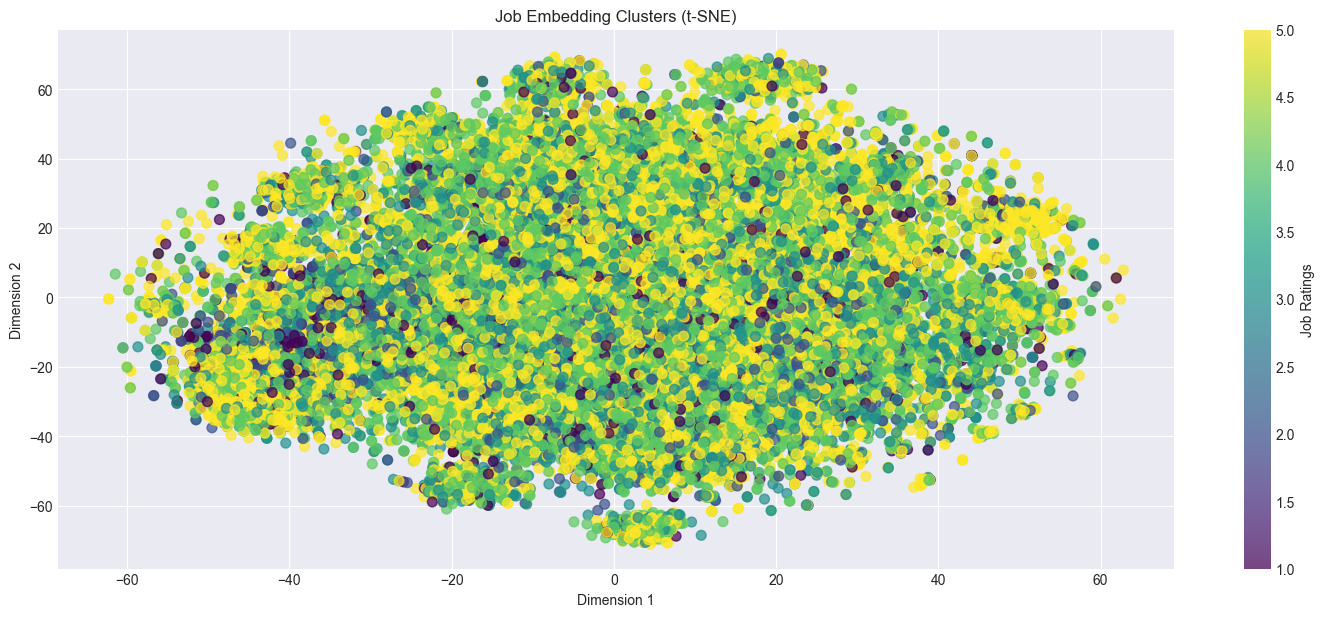

In [47]:
# visualization of the model using t-sne clusters
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
job_embeddings_2d = tsne.fit_transform(job_embeddings)
data2_cleaned['x'] = job_embeddings_2d[:, 0]
data2_cleaned['y'] = job_embeddings_2d[:, 1]

#plot
plt.figure(figsize=(18, 7))
plt.style.use('seaborn-v0_8-darkgrid')
plt.scatter(data2_cleaned['x'], data2_cleaned['y'], c=data2_cleaned['Cleaned Rating'], cmap='viridis', s=50, alpha=.7)
plt.colorbar(label="Job Ratings")
plt.title('Job Embedding Clusters (t-SNE)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


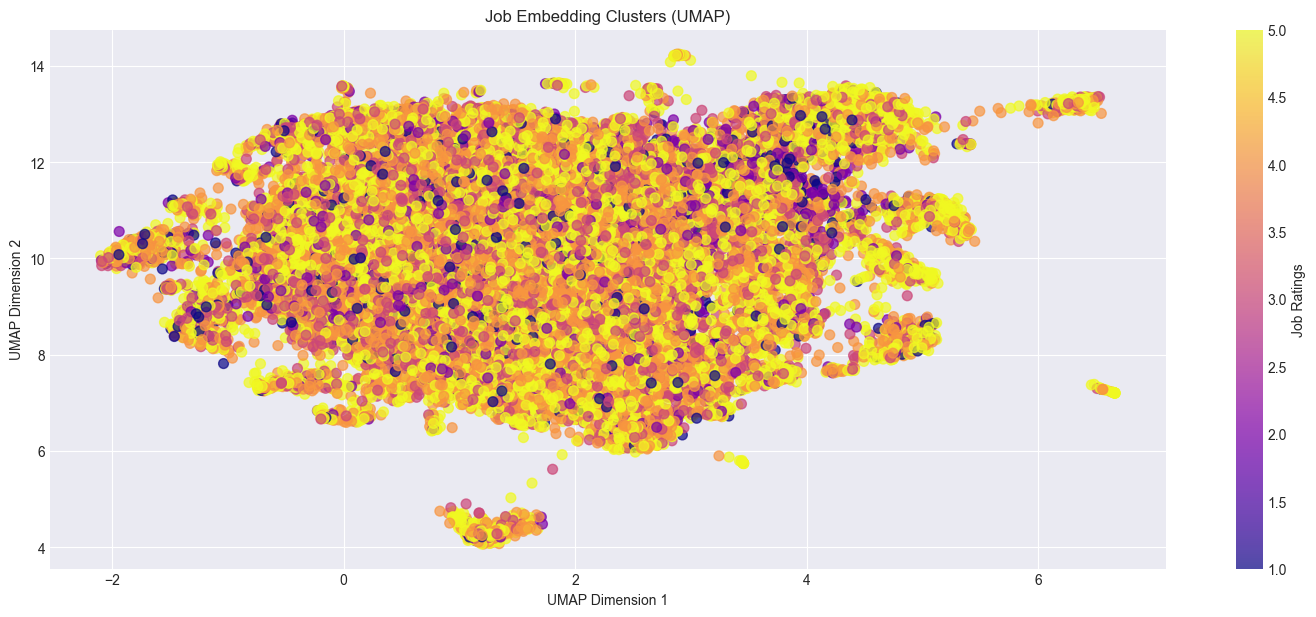

In [48]:
# visualization using UMAP
import umap
reducer = umap.UMAP(n_neighbors=15, min_dist=.1, random_state=42)
job_embedding_umap = reducer.fit_transform(job_embeddings)

plt.figure(figsize=(18, 7))
plt.scatter(job_embedding_umap[:, 0],job_embedding_umap[:, 1],
           c=data2_cleaned['Cleaned Rating'], cmap='plasma', s=50, alpha=.7)
plt.colorbar(label="Job Ratings")
plt.title('Job Embedding Clusters (UMAP)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

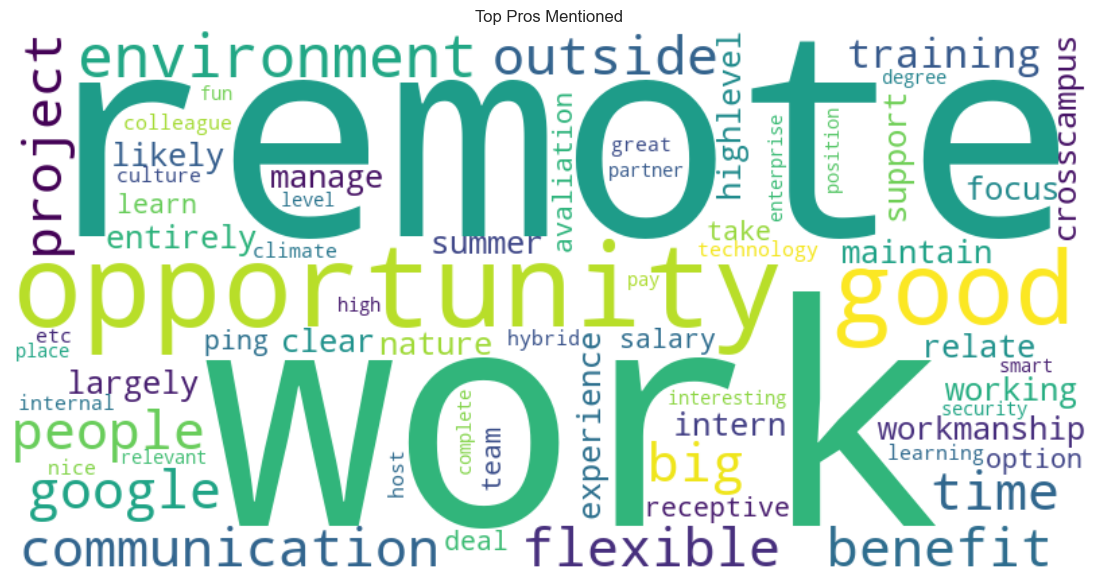

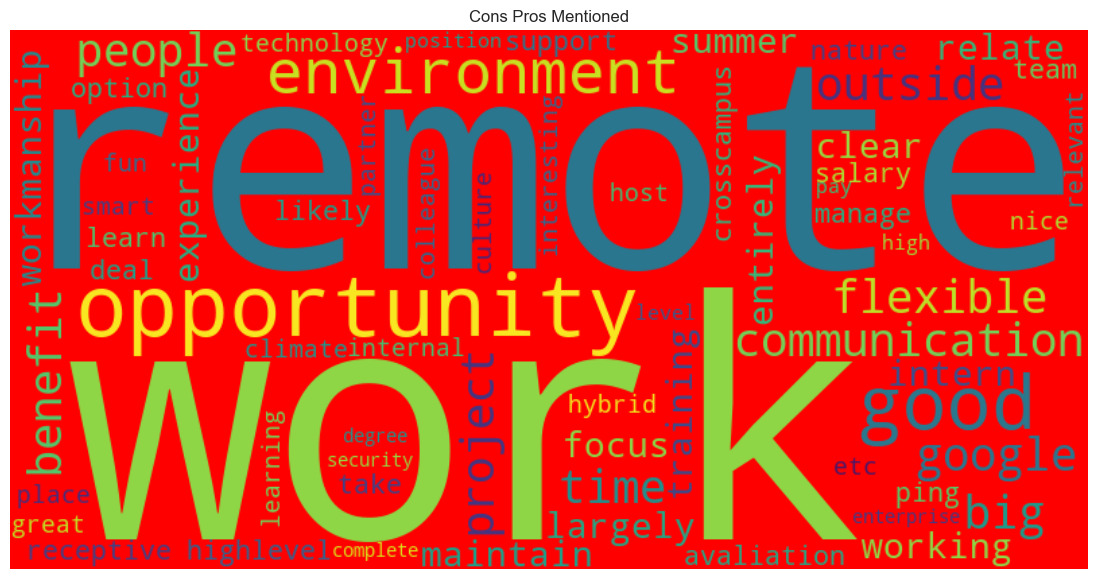

In [49]:
# word clouds for pros and cons of top matches
from wordcloud import WordCloud
pros_text = ' '.join(top_matches['Pros Clean'].dropna())
cons_text = ' '.join(top_matches['Cons Clean'].dropna())

# pros
plt.figure(figsize=(18, 7))
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(pros_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Top Pros Mentioned")
plt.show()

# cons
plt.figure(figsize=(18, 7))
wordcloud = WordCloud(width=800, height=400, background_color="red").generate(pros_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Cons Pros Mentioned")
plt.show()

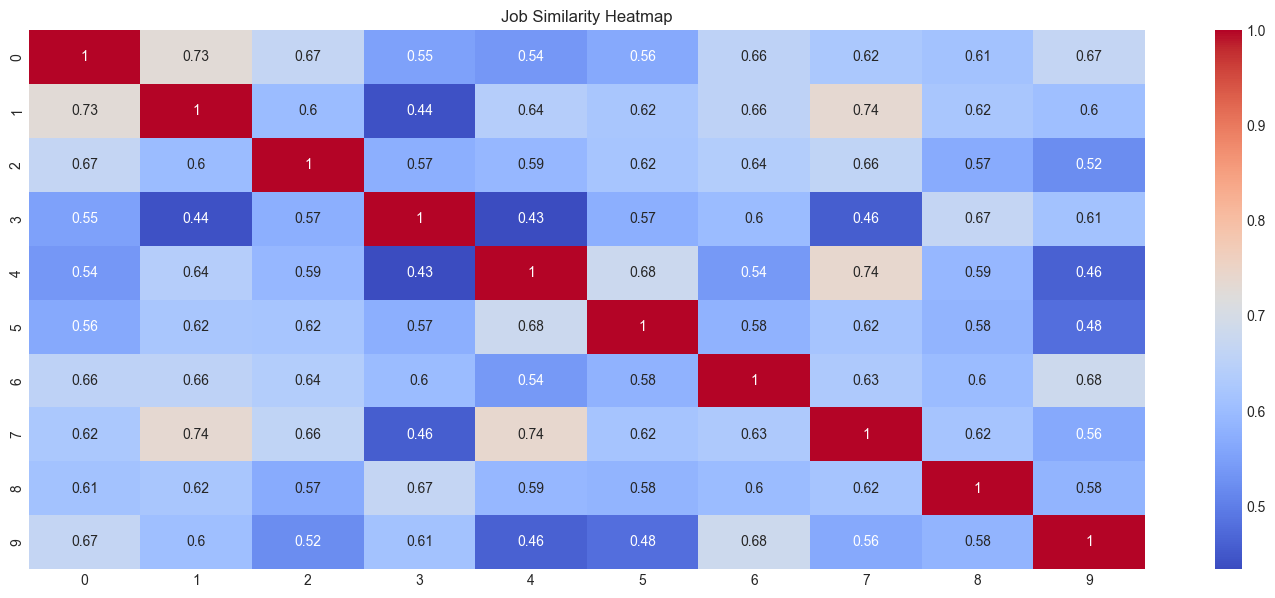

In [50]:
# Pick top 10 similar jobs and compare their text similarity
similar_jobs = top_matches['combined_text'].head(10).tolist()
sim_matrix = cosine_similarity(model.encode(similar_jobs))

plt.figure(figsize=(18,7))
sns.heatmap(sim_matrix, cmap='coolwarm', annot=True)
plt.title('Job Similarity Heatmap')
plt.show()

In [51]:
# Normalize Job Ratings
scaler = MinMaxScaler()
data2_cleaned['Cleaned Rating'] = data2_cleaned['Cleaned Rating'].fillna(data2_cleaned['Cleaned Rating'].mean())
data2_cleaned['Rating_scaled'] = scaler.fit_transform(data2_cleaned[['Cleaned Rating']])

# structured Feature Engineering

In [52]:
# Encode
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
status_encoded = encoder.fit_transform(data2_cleaned[['Role_Type']])

status_cols = encoder.get_feature_names_out(['Role_Type'])
status_df = pd.DataFrame(status_encoded, columns=status_cols)

data2_cleaned = pd.concat([data2_cleaned.reset_index(drop=True), status_df.reset_index(drop=True)], axis=1)

In [53]:
# Combine Structured + Text Embeddings
# structured_features = np.concatenate(
#     [data2_cleaned[['Rating_scaled']].values, status_df.values],
#     axis=1
# )
structured_features = status_df.values  # Only categorical or numeric job info
hybrid_features = np.concatenate([job_embeddings, structured_features], axis=1)

In [54]:
# save for later
np.save("hybrid_features.npy", hybrid_features)

In [55]:
hybrid_features

array([[ 0.00984046,  0.08766761,  0.02423352, ...,  0.        ,
         0.        ,  0.        ],
       [-0.06434164,  0.05886243, -0.01085036, ...,  0.        ,
         0.        ,  0.        ],
       [-0.01632242,  0.0939292 , -0.03862968, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.0267743 ,  0.03906356, -0.00270649, ...,  0.        ,
         0.        ,  0.        ],
       [-0.01896854,  0.04508679, -0.03752998, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02646735,  0.03551805, -0.02859724, ...,  0.        ,
         0.        ,  0.        ]])

In [56]:
data2_cleaned.columns

Index(['Job Title Clean', 'Job Title Entities', 'Pros Clean', 'Pros Entities',
       'Cons Clean', 'Cons Entities', 'Cleaned Status', 'Cleaned Rating',
       'Time', 'Employment_Type', 'Role_Type', 'Duration', 'Company_Name',
       'combined_text', 'similarity', 'x', 'y', 'Rating_scaled',
       'Role_Type_contractor', 'Role_Type_employee', 'Role_Type_freelancer',
       'Role_Type_internship', 'Role_Type_temporary'],
      dtype='object')

In [57]:
# normalize hybrid features
hybrid_features_norm = normalize(hybrid_features)

In [58]:
# user structured preferences
user_df = pd.DataFrame({'Role_Type': ['Internship']})

# transform using same encoder and scaler pipeline
user_status_pref = encoder.transform(user_df[['Role_Type']])
user_structured = user_status_pref

# combine embeddings
user_embedding = model.encode([user_query])
user_hybrid = np.concatenate([user_embedding, user_structured], axis=1)
user_hybrid_norm = normalize(user_hybrid)

In [59]:
# compute similarities
from sklearn.metrics.pairwise import cosine_similarity
similarity_scores = cosine_similarity(user_hybrid_norm, hybrid_features_norm)[0]
data2_cleaned["hybrid_similarity"] = similarity_scores
top_matches = data2_cleaned.sort_values(by="hybrid_similarity", ascending=False).head(10)
top_matches[['Company_Name', 'Job Title Clean', 'hybrid_similarity', 'Cleaned Rating', 'Role_Type']]

,Company_Name,Job Title Clean,hybrid_similarity,Cleaned Rating,Role_Type
406,Safaricom,remote support engineer,0.473295,5.0,internship
3564,Google,software engineering intern ii,0.427455,5.0,employee
92,Safaricom,technology intern,0.425961,4.0,contractor
19292,IBM,specialist infrastructure architecture,0.417034,5.0,employee
831,Google,research intern,0.409872,5.0,employee
22205,Cisco,digital channel intern,0.406659,5.0,employee
15663,IBM,cloud consulting intern,0.404998,4.0,employee
10707,IBM,software developer intern,0.403042,3.0,employee
24412,Cisco,senior principal software engineer,0.401167,4.0,employee
13386,IBM,security intern,0.399473,4.0,employee


In [60]:
# visualize top 10 using heatmap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(hybrid_features, data2_cleaned['Cleaned Rating'], test_size=.2, random_state=42)
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

preds = model_rf.predict(X_test)
mse = mean_squared_error(y_test, preds)
print(f"MSE: {mse}")

MSE: 0.9739766819724496


In [61]:
# # cluster profiling
# cluster_summary = data2_cleaned.groupby('cluster')[['Cleaned Rating']].mean()
# cluster_summary

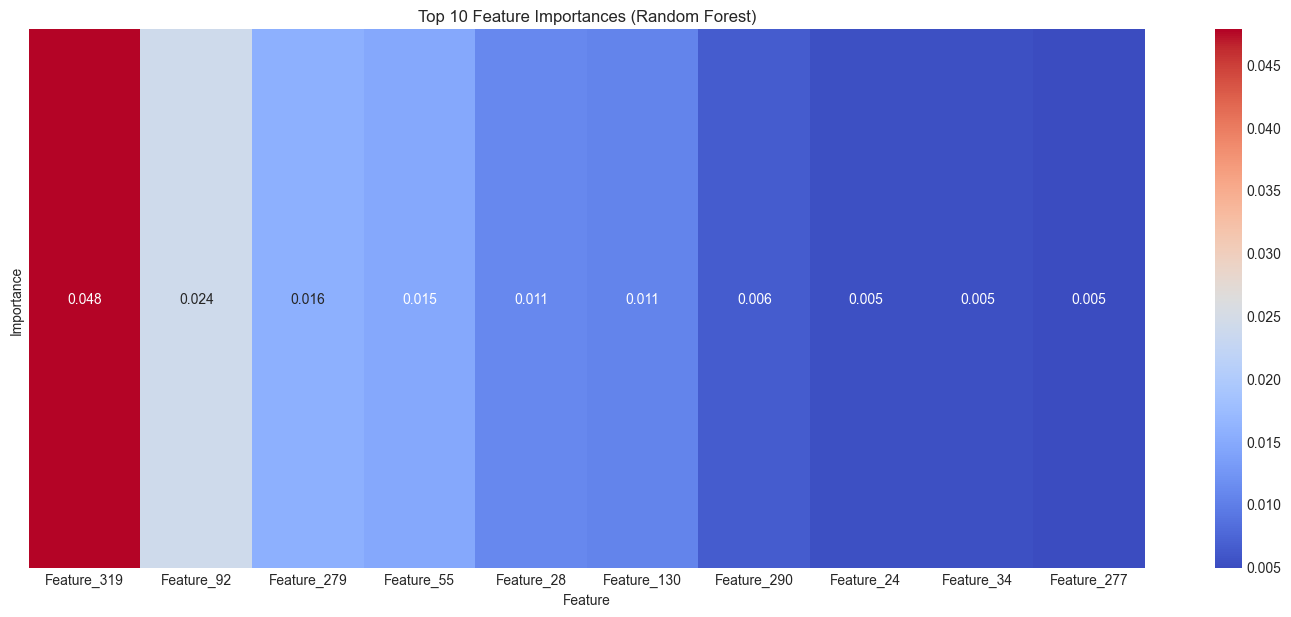

In [62]:
# visualize 
importances = model_rf.feature_importances_
feature_labels = [f'Feature_{i}' for i in range(hybrid_features.shape[1])]

indices = importances.argsort()[-10:][::-1]
top_features = pd.DataFrame({
    "Feature": [feature_labels[i] for i in indices],
    "Importance": importances[indices]
})
# Plot heatmap
plt.figure(figsize=(18, 7))
sns.heatmap(top_features.set_index("Feature").T, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

In [63]:
# Define a cleaning function
def preprocess_query_spacy(text):
    """
    A function that converts a text that says:
    i'm looking for an internship that lets me work from home and pays well
    into
    look internship let work home pay well"""
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct and not token.is_space
    ]
    return " ".join(tokens)

In [64]:
# embed the cleaned query
user_input = "i want a remote internship that pays well and offers experience"
cleaned_query = preprocess_query_spacy(user_input)
user_embedding = model.encode([cleaned_query], normalize_embeddings=True)

In [65]:
user_hybrid = np.concatenate([user_embedding, user_structured], axis=1)

In [66]:
similarity_scores = cosine_similarity(user_hybrid_norm, hybrid_features_norm)[0]
data2_cleaned["hybrid_similarity"] = similarity_scores
top_matches = data2_cleaned.sort_values(by="hybrid_similarity", ascending=False).head(10)
top_matches[['Company_Name', 'Job Title Clean', 'hybrid_similarity', 'Cleaned Rating', 'Role_Type']]

,Company_Name,Job Title Clean,hybrid_similarity,Cleaned Rating,Role_Type
406,Safaricom,remote support engineer,0.473295,5.0,internship
3564,Google,software engineering intern ii,0.427455,5.0,employee
92,Safaricom,technology intern,0.425961,4.0,contractor
19292,IBM,specialist infrastructure architecture,0.417034,5.0,employee
831,Google,research intern,0.409872,5.0,employee
22205,Cisco,digital channel intern,0.406659,5.0,employee
15663,IBM,cloud consulting intern,0.404998,4.0,employee
10707,IBM,software developer intern,0.403042,3.0,employee
24412,Cisco,senior principal software engineer,0.401167,4.0,employee
13386,IBM,security intern,0.399473,4.0,employee


In [69]:
def generate_relevance_labels(df, query):
    """
    create rule-based relevance labels for each company based on user query keywords
    Returns a dataframe with a new 'relevant column' """
    query = query.lower()
    

    

    score = (1.0 * is_remote) + (1.0 * is_internship) + (.5 * is_high_pay)

    return 1 if score >= 1.5 else 0

data2_cleaned["relevance"] = data2_cleaned.apply(lambda row: generate_relevance_labels(row, user_query), axis=1)

,Job Title Clean,Job Title Entities,Pros Clean,Pros Entities,Cons Clean,Cons Entities,Cleaned Status,Cleaned Rating,Time,Employment_Type,...,y,Rating_scaled,Role_Type_contractor,Role_Type_employee,Role_Type_freelancer,Role_Type_internship,Role_Type_temporary,hybrid_similarity,relevant,relevance
0,brand ambassador,"{'NER': [], 'ROLES': ['brand', 'brand ambassador', 'ambassador']}",flexible hour supportive team good training fun work environment opportunity travel,"{'NER': [], 'ROLES': ['good', 'training']}",inconsistent hour limited career growth commission structure unclear stand long hour slow communication,"{'NER': [('hours', 'TIME'), ('long hours', 'TIME')], 'ROLES': []}","Former Employee, More Than 1 Year",5.0,2025-08-08,Former,...,12.696184,1.00,0.0,1.0,0.0,0.0,0.0,0.229656,0,0
1,senior mobile developer,"{'NER': [], 'ROLES': ['senior mobile developer', 'mobile developer', 'developer']}",great gain experience large scale enterprise application,"{'NER': [], 'ROLES': ['great']}",lot shift priority,"{'NER': [], 'ROLES': []}",Contract,4.0,2025-07-28,Current,...,45.070080,0.75,1.0,0.0,0.0,0.0,0.0,0.232524,1,0
2,project manager,"{'NER': [], 'ROLES': ['project', 'project manager', 'manager']}",strong support professional growth training exposure largescale impactful project kenya competitive salary performancebased bonus,"{'NER': [('kenya', 'GPE')], 'ROLES': ['support', 'professional', 'training', 'projects']}",occasional tight deadline highpressure timeline bureaucracy delay project signoff,"{'NER': [], 'ROLES': ['project']}","Former Employee, More Than 3 Years",4.0,2025-07-15,Former,...,-2.773927,0.75,0.0,1.0,0.0,0.0,0.0,0.159976,1,0
3,ict technician,"{'NER': [('ict', 'ORG')], 'ROLES': ['ict', 'ict technician', 'technician']}",working experience good,"{'NER': [], 'ROLES': ['good']}",major drawback talk,"{'NER': [], 'ROLES': []}",Former Employee,5.0,2025-07-18,Former,...,23.654274,1.00,0.0,1.0,0.0,0.0,0.0,0.193931,0,0
4,intern,"{'NER': [], 'ROLES': ['intern']}",great work environment regular bonus,"{'NER': [], 'ROLES': ['great']}",think,"{'NER': [], 'ROLES': []}",Internship,5.0,2025-07-15,Former,...,64.173233,1.00,0.0,0.0,0.0,1.0,0.0,0.369312,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25036,planning officer,"{'NER': [], 'ROLES': ['planning officer', 'officer']}",good medical cover employee,"{'NER': [], 'ROLES': ['good']}",term employment contract,"{'NER': [], 'ROLES': []}",Former Employee,4.0,2022-03-31,Former,...,-21.386141,0.75,0.0,1.0,0.0,0.0,0.0,0.157647,0,0
25037,senior business analyst,"{'NER': [], 'ROLES': ['senior business analyst', 'business analyst', 'analyst']}",good learning potential staff,"{'NER': [], 'ROLES': ['good']}",work schedule flexible,"{'NER': [], 'ROLES': []}",Current Employee,4.0,2022-05-14,Current,...,-5.045511,0.75,0.0,1.0,0.0,0.0,0.0,0.165790,0,0
25038,senior program manager,"{'NER': [], 'ROLES': ['senior program', 'senior program manager', 'program', 'program manager', 'manager']}",potential great social impact,"{'NER': [], 'ROLES': ['great']}",slow time,"{'NER': [], 'ROLES': []}",Former Employee,3.0,2016-05-02,Former,...,-27.537323,0.50,0.0,1.0,0.0,0.0,0.0,0.145502,0,0
25039,ban assurance officer,"{'NER': [], 'ROLES': ['ban assurance officer', 'assurance', 'officer']}",medical insurance cover low interest loan staff,"{'NER': [], 'ROLES': []}",bad management appropriate pay extremely long work hour extensive workload toxic work culture,"{'NER': [('hours', 'TIME')], 'ROLES': ['management']}","Former Employee, More Than 1 Year",1.0,2022-10-17,Former,...,-21.415693,0.00,0.0,1.0,0.0,0.0,0.0,0.171701,1,0
